<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
# U4S1 Libraries
import os
import re
from nltk.stem import PorterStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from collections import Counter
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [3]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [4]:
yelp.isna().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

In [5]:
yelp.shape

(10000, 9)

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [6]:
nlp = spacy.load("en_core_web_lg")

In [7]:
def tokenize(doc):
    
    return [token for token in simple_preprocess(doc) if token not in STOPWORDS]

In [8]:
yelp['token']= yelp['text'].apply(tokenize)

yelp['token']

0       [beware, fake, fake, fake, small, business, lo...
1       [came, lunch, togo, service, quick, staff, fri...
2       [ve, vegas, dozens, times, stepped, foot, circ...
3       [went, night, closed, street, party, best, act...
4       [stars, bad, price, lunch, seniors, pay, eatin...
                              ...                        
9995    [family, hungry, subway, open, hours, guy, wor...
9996    [wife, came, couple, friends, sever, excited, ...
9997    [food, ok, brag, food, hot, items, tasty, horr...
9998    [today, visit, great, love, enjoy, town, squar...
9999    [absolute, worst, place, stayed, year, life, t...
Name: token, Length: 10000, dtype: object

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [9]:
# Create vector rep. of reviews
vectorizer = TfidfVectorizer(stop_words = 'english')
s_matrix = vectorizer.fit_transform(yelp['text'])

In [10]:
# Write a fake review and query for the 10 most similiar reviews
vector_reviews = pd.DataFrame(s_matrix.todense(),
                              columns=vectorizer.get_feature_names())

In [11]:
# Print the text of the reviews. Do you notice any patterns? 
model = NearestNeighbors(n_neighbors=10, algorithm='kd_tree')

In [12]:
model.fit(vector_reviews)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [13]:
# fake_review = ['This place was awful. Terrible service, unfriendly staff, bad bad bad.']
fake_review = ['amazing good awesome wonderful']

In [14]:
fake_s_matrix = vectorizer.transform(fake_review)

In [15]:
fake_yelp = fake_s_matrix.todense()

In [16]:
# Get 10 most similar reviews
for review in model.kneighbors(fake_yelp)[1]:
    print(yelp['text'][review][:10])

335     Love love love. The limeade was awesome. The s...
3127    Just amazing , the food was very good. The che...
2880    I love this place this is my and my boyfriend'...
3044    I love the customer service,  the store is alw...
5701    This place is absolutely amazing. The food is ...
4189    Amazing everyone of them ! I love the decor an...
4094    It's wonderful to find a coffee shop that care...
6023    Amazing is the right word.  Amazing customer s...
1223    New to the area. Amazing food can't get enough...
5526    We love coming here. The combination of two wo...
Name: text, dtype: object


## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [17]:
# Create a piepline object with a sklearn CountVectorizer or TfidfVector and any sklearn classifier. 
# Use that pipeline to estimate a model to predict stars

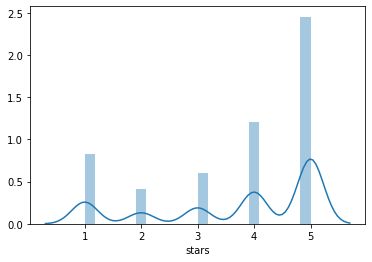

In [18]:
sns.distplot(yelp['stars']);

In [19]:
tfidf_v = TfidfVectorizer(stop_words='english', max_features=1825, max_df=0.9)
mnb = MultinomialNB()

pipe = Pipeline([('vect', tfidf_v), ('clf', mnb)])


pipe.fit(yelp['text'], yelp['stars'])

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=1825,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
pred = pipe.predict(fake_review)


In [21]:
# Grid search
# Note to self: Use n_jobs=-1 while on laptop
# Best: {'vect__max_df': 0.3, 'vect__max_features': 1500, 'vect__min_df': 35}

params = {
    'vect__max_df': (0.2, 0.3),
    'vect__min_df': (30, 35, 40),
    'vect__max_features': (500, 1000, 1500, 2000)
}

grid_search = GridSearchCV(pipe, params, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(yelp['text'], yelp['stars'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   38.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=1825,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [22]:
# Tuning
grid_search.best_params_

{'vect__max_df': 0.2, 'vect__max_features': 2000, 'vect__min_df': 35}

In [23]:
grid_pred = grid_search.predict(fake_review)

# Good fake review = 5, bad fake review = 1!
grid_pred

array([5])

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Keep the `iterations` parameter at or below 5 to reduce run time
    - The `workers` parameter should match the number of physical cores on your machine.
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [24]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

Learn the vocubalary of the yelp data:

In [25]:
id2word = corpora.Dictionary(yelp['token'])

Create a bag of words representation of the entire corpus

In [26]:
corpus = [id2word.doc2bow(text) for text in yelp['token']]

Your LDA model should be ready for estimation: 

In [27]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=6,
                   num_topics = 10 # You can change this parameter
                  )

Create 1-2 visualizations of the results

In [28]:
# Format LDA topics

In [29]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [30]:
# use the most important 3 words of a topic
topics = [' '.join(t[0:3]) for t in words]

In [31]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
food place service

------ Topic 1 ------
good food place

------ Topic 2 ------
place food good

------ Topic 3 ------
great service food

------ Topic 4 ------
good great place

------ Topic 5 ------
food place great

------ Topic 6 ------
place great food

------ Topic 7 ------
food place good

------ Topic 8 ------
good food place

------ Topic 9 ------
great food good



In [32]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.000296 -0.002123       1        1  10.604125
6     -0.002321  0.000580       2        1  10.465526
4     -0.001132  0.001219       3        1  10.359359
0     -0.000894 -0.000516       4        1  10.204204
3     -0.001010  0.005770       5        1  10.041224
5     -0.001884 -0.003990       6        1  10.005565
2     -0.001038  0.000062       7        1   9.915951
7     -0.001036 -0.000954       8        1   9.700730
8      0.005576 -0.000512       9        1   9.433590
1      0.004037  0.000466      10        1   9.269720, topic_info=            Term         Freq        Total Category  logprob  loglift
45       service  3500.000000  3500.000000  Default  30.0000  30.0000
208        great  4068.000000  4068.000000  Default  29.0000  29.0000
40          good  4553.000000  4553.000000  Default  28.0000  28.0000
39      friendly  1316.000000  1316.000000  Default  27.0000  27.0000
144         food  4804.000000  4804.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
264   experience   109.258797  1228.728271  Topic10  -6.0105  -0.0416
359    delicious   105.790833  1193.077637  Topic10  -6.0427  -0.0444
735         love   112.241783  1597.521118  Topic10  -5.9835  -0.2771
1266     ordered   106.585243  1469.016968  Topic10  -6.0352  -0.2450
30          said   102.508713  1148.096313  Topic10  -6.0742  -0.0375

[853 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
24794      9  0.350364      admitting
19737      3  0.175616  advertisement
19737      4  0.175616  advertisement
19737      5  0.175616  advertisement
19737      6  0.175616  advertisement
...      ...       ...            ...
22608      6  0.350653           zoey
21303      2  0.525201     とても気に入りました
21303      9  0.525201     とても気に入りました
21304      2  0.524917       探したお店でした
21304      9  0.524917       探したお店でした

[2503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 5, 1, 4, 6, 3, 8, 9, 2])

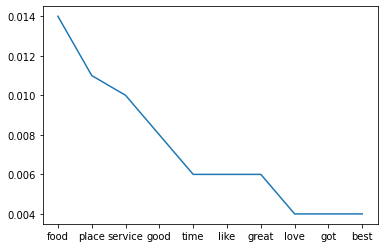

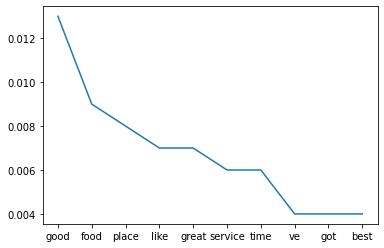

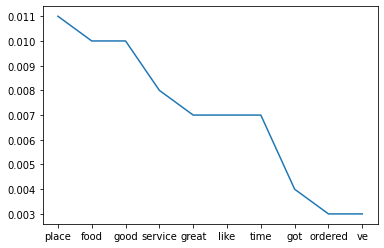

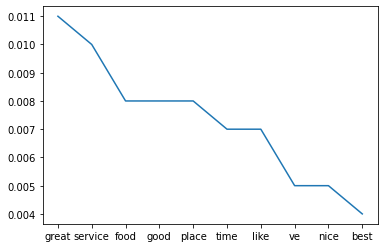

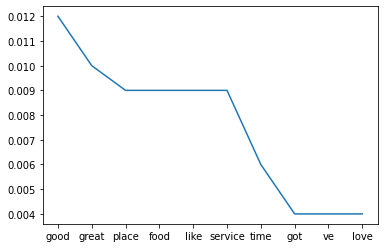

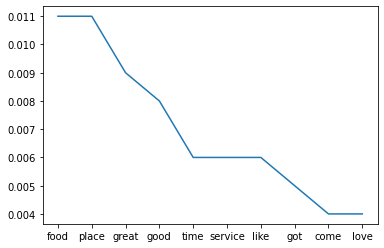

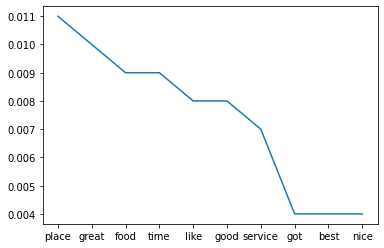

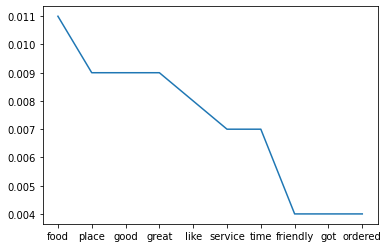

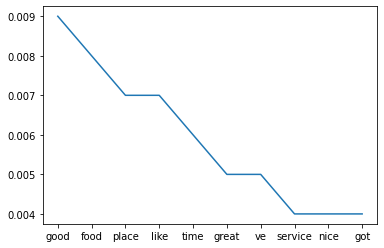

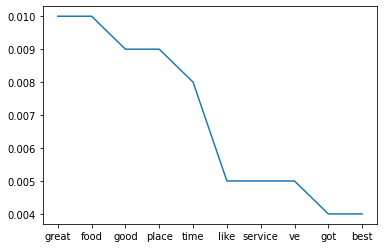

In [33]:
scores = [re.findall(r"\d+\.\d+", t[1]) for t in lda.print_topics()]

import matplotlib.pyplot as plt

for i in range(len(words)):
    ys = [float(li) for li in scores[i]]
    plt.plot(words[i], ys)
    plt.show()

In [34]:
def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    total_docs = len(docs)
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

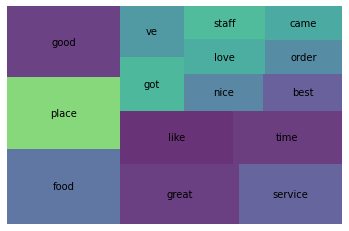

In [35]:
wc = count(yelp['token'])
top15= wc[wc['rank'] <= 15]

squarify.plot(sizes=top15['pct_total'], label=top15['word'], alpha=0.8)
plt.axis('off')
plt.show()

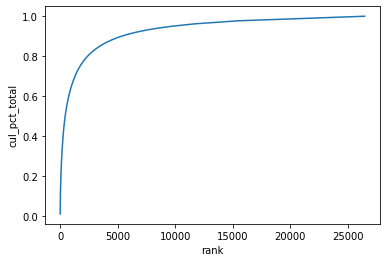

In [36]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [37]:
# In markdown, write 1-2 paragraphs of analysis on the results of your topic model

<h1>Analysis</h1>
<p>
    I have learned over the course of this sprint and the result of this topic model that a lot
    of human language is almost completely meaningless and/or means the exact same thing as
    another word. Words like "good, great, nice, like" are frequently used but while reading the 
    reviews I found that there wasn't really a difference in how positive the reviews were depending
    on if they said "I really liked it" or "It was really good". Other words such as "staff, order, came,
    place, service" also appeared frequently but without context these don't mean much to us. As someone
    could write a review saying "This PLACE was gross and the SERVICE was bad" and "This PLACE was clean
    and the SERVICE was good" and the model wouldn't know from just looking at PLACE and SERVICE that a review
    was positive or negative. Overall, cleaning your text data and focusing on words that don't need context
    would be the most important factors in this model.
   
</p>

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)